In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn optuna joblib openpyxl
!pip install scikit-learn==1.0.2 # Asegura compatibilidad de IterativeImputer si es necesario

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import joblib # Para guardar y cargar el modelo

# Importaciones de Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import IterativeImputer # Se mantiene por si hay otros NaNs, aunque los imputamos antes

# Importaciones de XGBoost
import xgboost as xgb

# Importaciones de Optuna
import optuna

In [ ]:
# --- Configuración de rutas (AJUSTAR SEGÚN TU ENTORNO) ---
# Si estás en Google Colab y quieres usar Drive, DESCOMENTA estas líneas:
print("Montando Google Drive...")
drive.mount('/content/drive')
print("Google Drive montado.")

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado.


In [ ]:
# --- Configuración de rutas (AJUSTAR SEGÚN TU ENTORNO) ---
# Si estás en Google Colab y quieres usar Drive, DESCOMENTA estas líneas:
print("Montando Google Drive...")
drive.mount('/content/drive')
print("Google Drive montado.")
input_file_path = '/content/drive/MyDrive/MP_20253/ImputadoRF_21.xlsx'
output_dir_path = '/content/drive/MyDrive/MP_20253/'

# Si estás en un entorno local, COMENTA las líneas de drive.mount y usa rutas locales:
# input_file_path = 'Data_junto_imputado_final.xlsx' # Archivo debe estar en la misma carpeta que el script
# output_dir_path = './' # Guardar salidas en la misma carpeta que el script

model_output_name = 'xgboost_model_pm10_sa_next_hour.joblib'
graph_output_name = 'pm10_sa_prediction_next_hour_plot.png'

model_output_path = os.path.join(output_dir_path, model_output_name)
graph_output_path = os.path.join(output_dir_path, graph_output_name)

# --- 1. Cargar el DataFrame ---
print(f"Cargando datos desde: {input_file_path}")
try:
    df = pd.read_excel(input_file_path)
    print("Datos cargados exitosamente.")
except FileNotFoundError:
    print(f"Error: El archivo no se encontró en la ruta '{input_file_path}'.")
    print("Por favor, verifica la ruta y que el archivo exista. Si estás en Colab, asegúrate de montar Drive y descomentar las rutas de Drive.")
    exit()
except Exception as e:
    print(f"Error al cargar el archivo Excel: {e}")
    exit()

print("\nPrimeras 5 filas del DataFrame cargado:")
print(df.head())
print("\nInformación del DataFrame cargado:")
print(df.info())
print(f"Número total de filas en el dataset: {len(df)}")


Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado.
Cargando datos desde: /content/drive/MyDrive/MP_2025/regresionRF.xlsx
Datos cargados exitosamente.

Primeras 5 filas del DataFrame cargado:
   ID  PM10_SA  PM2_5_SA  NO2_SA  PM10_SJL  PM2_5_SJL  NO2_SJL  PM10_SMP  \
0   1   103.93      13.4   24.14      98.9       41.1    25.02     58.03   
1   2   293.73     102.4   38.82     126.9       72.1    40.08    174.90   
2   3   168.25     118.8   73.17     215.7      173.2    80.92    159.14   
3   4   165.57      87.9   25.13     163.5      143.8    25.16     51.42   
4   5    81.51      66.7   21.56     117.6       92.2    29.26     49.25   

   PM2_5_SMP  NO2_SMP  PM10_VMT  PM2_5_VMT  NO2_VMT  PM10_SB  PM2_5_SB  NO2_SB  
0       29.2    21.45     84.24       19.1   11.410   76.477      24.8  23.050  
1       51.3    85.34    608.38      140.7   48.030  143.430     

In [ ]:
# --- 2. Definir Target (y) y Características (X) para predicción 'una hora adelante' ---
# Target: PM10_SA en el siguiente periodo de tiempo (t+1)
# Se crea la columna de target desplazada una posición hacia arriba (shift(-1)).
# Esto significa que la fila actual 'i' contendrá el PM10_SA de la fila 'i+1'.
# PM10_SA(t+1) = f(Características(t))
df_original_y_values = df['PM10_SA'].copy() # Guardar los valores originales para la gráfica
df['PM10_SA_NEXT_HOUR'] = df['PM10_SA'].shift(-1)
target_column_name = 'PM10_SA_NEXT_HOUR' # Cambiado para claridad en el código

# Características (X): Todas las columnas de contaminantes (incluido el PM10_SA actual)
# Esto permite que el modelo use el PM10_SA del momento actual (t) para predecir el futuro (t+1).
features = [
    'PM10_CAR_IMP', 'PM2_5_CAR_IMP', 'NO2_CAR_IMP',
    'PM10_CM_IMP', 'PM2_5_CM_IMP', 'NO2_CM_IMP',
    'PM10_VMT_IMP', 'PM2_5_VMT_IMP', 'NO2_VMT_IMP',
    'PM10_SJL_IMP', 'PM2_5_SJL_IMP', 'NO2_SJL_IMP',
    'PM10_SMP_IMP', 'PM2_5_SMP_IMP', 'NO2_SMP_IMP',
    'PM10_SA_IMP', 'PM2_5_SA_IMP', 'NO2_SA_IMP',  # Ahora PM10_SA(t) es una característica para PM10_SA(t+1)
    'PM10_SB_IMP', 'PM2_5_SB_IMP', 'NO2_SB_IMP'
]

# Verificar que todas las características existan
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"\nError: Las siguientes características no se encontraron en el DataFrame: {missing_features}")
    print("Por favor, verifica los nombres de las columnas en tu archivo.")
    exit()

# Eliminar la última fila, ya que 'PM10_SA_NEXT_HOUR' será NaN allí
df.dropna(subset=[target_column_name], inplace=True)

X = df[features]
y = df[target_column_name]

print(f"\nVariable objetivo (y): {target_column_name}")
print(f"Número de características (X): {len(features)}")
print(f"Número total de filas después de la preparación para predicción adelante: {len(df)}")



Variable objetivo (y): PM10_SA_NEXT_HOUR
Número de características (X): 15
Número total de filas después de la preparación para predicción adelante: 82541


In [ ]:
# --- 3. División de Datos (80% Train, 20% Test) - Basado en orden cronológico (ID) ---
# Se asume que el DataFrame ya está ordenado por ID, lo cual es esencial para series de tiempo.
split_idx = int(0.8 * len(df))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nDivisión de datos:")
print(f"  Tamaño del conjunto de entrenamiento: {len(X_train)} filas")
print(f"  Tamaño del conjunto de prueba: {len(X_test)} filas")


# --- 4. Escalado de Datos (MinMaxScaler) ---
print("\nEscalando datos con MinMaxScaler...")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Reshape y_train y y_test para scaler_y (MinMaxScaler espera 2D array)
# .flatten() convierte de nuevo a 1D, que es lo que espera XGBoost
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("Escalado completado.")




División de datos:
  Tamaño del conjunto de entrenamiento: 66032 filas
  Tamaño del conjunto de prueba: 16509 filas

Escalando datos con MinMaxScaler...
Escalado completado.


In [ ]:
# --- 5. Optimización de Hiperparámetros con Optuna y TimeSeriesSplit ---
print("\n--- Iniciando optimización de hiperparámetros con Optuna y TimeSeriesSplit ---")

# Optuna necesita un nombre de estudio único si se ejecuta múltiples veces
study_name = "xgboost_pm10_sa_next_hour_optimization"
# Puedes usar un RDB (SQLite) para guardar y cargar estudios, útil si se detiene el proceso
# storage = f"sqlite:///{study_name}.db" # Descomentar para usar almacenamiento

def objective(trial):
    param = {
        'objective': 'reg:squarederror', # Para problemas de regresión
        'eval_metric': 'rmse', # Métrica de evaluación para Optuna (RMSE)
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # Rango de árboles
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # Rango de tasa de aprendizaje
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Profundidad máxima del árbol
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # Fracción de muestras para cada árbol
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Fracción de características para cada árbol
        'gamma': trial.suggest_float('gamma', 0.0, 0.5), # Regularización mínima de pérdida requerida
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Peso mínimo de la hoja
        'random_state': 42,
        'n_jobs': -1 # Usar todos los núcleos de CPU disponibles
    }

    model = xgb.XGBRegressor(**param)

    # TimeSeriesSplit para validación cruzada adecuada para series de tiempo
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        # CORRECCIÓN AQUÍ: y_train_scaled en lugar de y_val_fold
        y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, val_preds)))

    # Optuna busca minimizar el objetivo, por lo que devolvemos el RMSE promedio
    return np.mean(rmse_scores)


# Crear un estudio de Optuna y optimizar.
# n_trials: número de combinaciones de hiperparámetros a probar. Ajustar según el tiempo disponible.
# Puedes reducir n_trials (ej. 20-50) para pruebas más rápidas, o aumentarlo (100-200+) para una búsqueda más exhaustiva.
# Para guardar el estudio y poder reanudarlo (útil para muchos trials), descomenta las líneas 'storage'
study = optuna.create_study(direction='minimize', study_name=study_name) # , storage=storage, load_if_exists=True
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n--- Optimización de hiperparámetros completada. ---")
print(f"Mejores hiperparámetros encontrados: {study.best_params}")
print(f"Mejor RMSE en validación cruzada: {study.best_value:.4f}")

best_hyperparams = study.best_params



[I 2025-07-25 16:03:44,414] A new study created in memory with name: xgboost_pm10_sa_next_hour_optimization



--- Iniciando optimización de hiperparámetros con Optuna y TimeSeriesSplit ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-25 16:03:49,208] Trial 0 finished with value: 0.029052183684575666 and parameters: {'n_estimators': 870, 'learning_rate': 0.2971628211195147, 'max_depth': 10, 'subsample': 0.7030590060890118, 'colsample_bytree': 0.7297481132595449, 'gamma': 0.3167002578689411, 'min_child_weight': 3}. Best is trial 0 with value: 0.029052183684575666.
[I 2025-07-25 16:03:57,018] Trial 1 finished with value: 0.028090566238295735 and parameters: {'n_estimators': 879, 'learning_rate': 0.16336053033125383, 'max_depth': 9, 'subsample': 0.88300711614106, 'colsample_bytree': 0.9776486132238791, 'gamma': 0.02317803205047342, 'min_child_weight': 6}. Best is trial 1 with value: 0.028090566238295735.
[I 2025-07-25 16:04:00,327] Trial 2 finished with value: 0.028290931525777267 and parameters: {'n_estimators': 541, 'learning_rate': 0.20101327435640878, 'max_depth': 9, 'subsample': 0.7492363666598136, 'colsample_bytree': 0.8944860219337036, 'gamma': 0.1201157809005487, 'min_child_weight': 4}. Best is trial

In [ ]:
# --- 6. Entrenamiento del Modelo Final XGBoost con los Mejores Hiperparámetros ---
print("\nEntrenando el modelo final XGBoost con los mejores hiperparámetros...")
final_model = xgb.XGBRegressor(**best_hyperparams, objective='reg:squarederror', eval_metric='rmse', random_state=42, n_jobs=-1)
final_model.fit(X_train_scaled, y_train_scaled)
print("Modelo final entrenado.")


Entrenando el modelo final XGBoost con los mejores hiperparámetros...
Modelo final entrenado.


In [ ]:
# --- 7. Métricas de Evaluación ---

# Predicciones escaladas
y_train_pred_scaled = final_model.predict(X_train_scaled)
y_test_pred_scaled = final_model.predict(X_test_scaled)

# Invertir la escala de las predicciones a la escala original
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Asegurar que y_train y y_test también estén en el formato correcto para las métricas
y_train_actual = y_train.values
y_test_actual = y_test.values

# Función para calcular MAPE (Manejo de ceros para evitar divisiones por cero)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filtrar valores reales muy cercanos a cero para evitar inestabilidad en la división
    non_zero_mask = np.abs(y_true) > 1e-6 # Considerar 'cero' si el valor absoluto es muy pequeño
    if not np.any(non_zero_mask): # Si no hay valores no-cero válidos
        return np.nan # MAPE no es significativo

    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

print("\n--- Métricas de Evaluación ---")

# Métricas para TRAIN
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
mse_train = mean_squared_error(y_train_actual, y_train_pred)
r2_train = r2_score(y_train_actual, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

print("\nConjunto de Entrenamiento:")
print(f"  MAE: {mae_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  R2: {r2_train:.4f}")
print(f"  MAPE: {mape_train:.2f}%" if not np.isnan(mape_train) else "  MAPE: N/A (valores reales muy cercanos a cero)")


# Métricas para TEST
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mse_test = mean_squared_error(y_test_actual, y_test_pred)
r2_test = r2_score(y_test_actual, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("\nConjunto de Prueba:")
print(f"  MAE: {mae_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  R2: {r2_test:.4f}")
print(f"  MAPE: {mape_test:.2f}%" if not np.isnan(mape_test) else "  MAPE: N/A (valores reales muy cercanos a cero)")



--- Métricas de Evaluación ---

Conjunto de Entrenamiento:
  MAE: 12.6294
  RMSE: 19.0156
  MSE: 361.5936
  R2: 0.7349
  MAPE: 19.83%

Conjunto de Prueba:
  MAE: 7.5118
  RMSE: 11.1110
  MSE: 123.4539
  R2: 0.7795
  MAPE: 20.87%



Generando gráfica de datos reales vs. pronosticados...
Guardando gráfico de prueba en: pm10_sa_prediction_next_hour_plot.png
Gráfico de prueba guardado exitosamente.


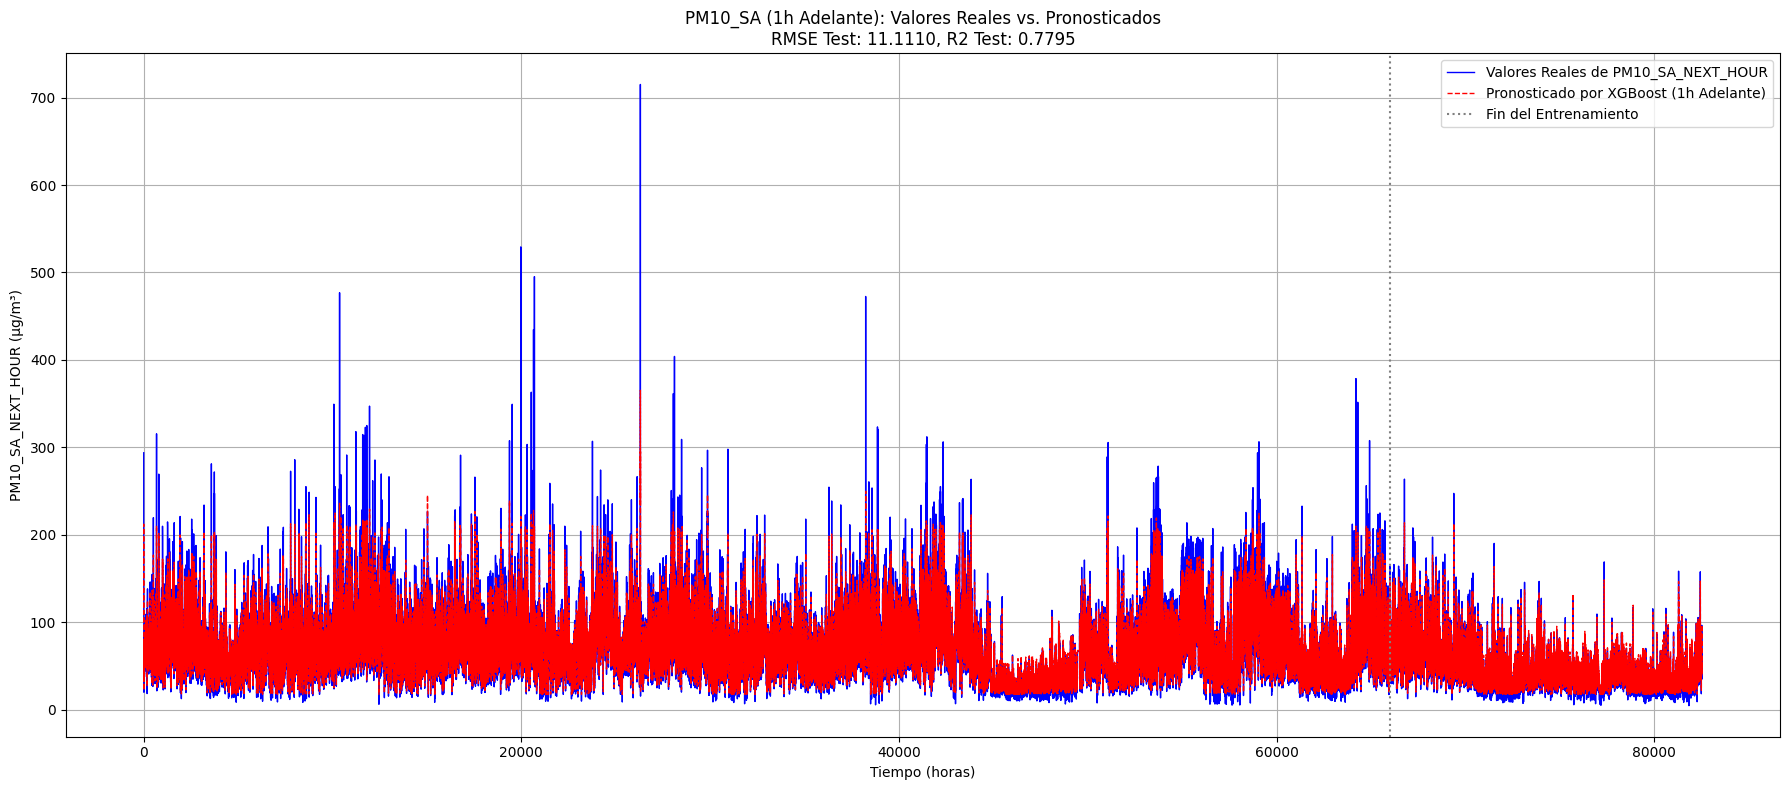

In [ ]:
# --- 8. Gráfica de Datos Reales vs. Pronosticados de PM10_SA (para 1 hora adelante) ---
print("\nGenerando gráfica de datos reales vs. pronosticados...")
plt.figure(figsize=(18, 8))

# Reconstruir el DataFrame para la gráfica, incluyendo el índice original (ID)
# Usamos el índice original del DataFrame 'df' después de dropna para alinear correctamente
df_plot_train = pd.DataFrame({
    'Actual': y_train_actual,
    'Predicted': y_train_pred,
    'Set': 'Entrenamiento'
}, index=X_train.index) # Usar el índice original de X_train

df_plot_test = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_test_pred,
    'Set': 'Prueba'
}, index=X_test.index) # Usar el índice original de X_test

# Concatenar para graficar todo en una sola línea de tiempo
results_df_plot = pd.concat([df_plot_train, df_plot_test])
results_df_plot = results_df_plot.sort_index() # Asegurarse de que esté ordenado por el índice

sns.lineplot(data=results_df_plot, x=results_df_plot.index, y='Actual', label=f'Valores Reales de {target_column_name}', color='blue', linewidth=1)
sns.lineplot(data=results_df_plot, x=results_df_plot.index, y='Predicted', label='Pronosticado por XGBoost (1h Adelante)', color='red', linestyle='--', linewidth=1)

# Añadir una línea vertical para indicar la división Train/Test
plt.axvline(x=X_train.index[-1], color='gray', linestyle=':', label='Fin del Entrenamiento')

plt.title(f'PM10_SA (1h Adelante): Valores Reales vs. Pronosticados\nRMSE Test: {rmse_test:.4f}, R2 Test: {r2_test:.4f}')
plt.xlabel('Tiempo (horas)')
plt.ylabel(f'{target_column_name} (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# --- Guardar el gráfico ANTES de mostrarlo ---
print(f"Guardando gráfico de prueba en: {graph_output_name }")
try:
    plt.savefig(graph_output_name )
    print("Gráfico de prueba guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el gráfico de prueba: {e}")

plt.show()




In [ ]:
# --- 9. Guardar el modelo entrenado y la gráfica ---
# Asegúrate de que el directorio de salida exista
os.makedirs(output_dir_path, exist_ok=True)

print(f"\nGuardando modelo en: {model_output_path}")
try:
    joblib.dump(final_model, model_output_path)
    print("Modelo entrenado guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

print(f"Guardando gráfica en: {graph_output_path}")
try:
    plt.savefig(graph_output_path)
    print("Gráfica guardada exitosamente.")
except Exception as e:
    print(f"Error al guardar la gráfica: {e}")

print("\nProceso completo: Modelado XGBoost de PM10_SA (1 hora adelante) finalizado y resultados guardados.")


Guardando modelo en: /content/drive/MyDrive/MP_2025/xgboost_model_pm10_sa_next_hour.joblib
Modelo entrenado guardado exitosamente.
Guardando gráfica en: /content/drive/MyDrive/MP_2025/pm10_sa_prediction_next_hour_plot.png
Gráfica guardada exitosamente.

Proceso completo: Modelado XGBoost de PM10_SA (1 hora adelante) finalizado y resultados guardados.


<Figure size 640x480 with 0 Axes>